In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from taskchain.task import Config

from rcpl import config
from rcpl.rcpl import Experiment

DEVICE = 'cuda'

In [3]:
config_path = config.CONFIGS_DIR / 'model' / 'fixed' / 'gru4-custom' / 'gru6.yaml'
conf = Config(
    config.TASKS_DIR,  # where Taskchain data should be stored
    config_path,
    context={'device': DEVICE},
    global_vars=config,  # set global variables
)
chain = conf.chain()
chain.set_log_level('CRITICAL')

In [4]:
chain

|                              | name                         | group   | namespace   | computed   |
|:-----------------------------|:-----------------------------|:--------|:------------|:-----------|
| real_experiment              | real_experiment              |         |             |            |
| dataset_info                 | dataset_info                 |         |             | True       |
| unscale_params_torch         | unscale_params_torch         |         |             |            |
| loss_func                    | loss_func                    |         |             |            |
| dataset_dir                  | dataset_dir                  |         |             | True       |
| train_dataset                | train_dataset                |         |             |            |
| val_dataset                  | val_dataset                  |         |             |            |
| unscale_params               | unscale_params               |         |             |            |
| get_random_pseudo_experiment | get_random_pseudo_experiment |         |             |            |
| train_model                  | train_model                  |         |             | True       |
| choose_model                 | choose_model                 |         |             |            |
| trained_model                | trained_model                |         |             |            |
| model_info                   | model_info                   |         |             |            |
| get_crlb                     | get_crlb                     |         |             |            |
| validate_crlb                | validate_crlb                |         |             | True       |
| test_dataset                 | test_dataset                 |         |             |            |
| scale_params_torch           | scale_params_torch           |         |             |            |
| model_metrics                | model_metrics                |         |             | True       |
| experiment                   | experiment                   |         |             |            |

In [5]:
#chain.train_model.force().value

In [6]:
# cn = chain.choose_model.force().value
# # to choose a checkpoint version instead of the last one
# cn.available_checkpoints
# net = cn(55999)

In [8]:
net = chain.trained_model.value
torch_exp = torch.unsqueeze(torch.from_numpy(chain.real_experiment.value['2023-08-27']), 0).float().to(DEVICE)
net.eval()
with torch.no_grad():
    theta_hat = net(torch_exp)

In [11]:
unscaled_theta_prediction = chain.unscale_params_torch.value(theta_hat).cpu().numpy().tolist()[0]
unscaled_theta_prediction

[98.67094421386719,
 2242.44140625,
 0.009104005992412567,
 7043.9580078125,
 1919.9488525390625,
 431.0171813964844,
 540.8895263671875,
 17.381473541259766,
 18.341548919677734,
 13.937408447265625,
 78.52299499511719]

In [12]:
unscaled_theta_prediction_dict = {key: val for key, val in zip(chain.dataset_info.value['param_labels'], chain.unscale_params_torch.value(theta_hat).cpu().numpy().tolist()[0])}
unscaled_theta_prediction_dict

{'k0': 98.67094421386719,
 'κ1': 2242.44140625,
 'κ2': 0.009104005992412567,
 'c1': 7043.9580078125,
 'c2': 1919.9488525390625,
 'c3': 431.0171813964844,
 'c4': 540.8895263671875,
 'a1': 17.381473541259766,
 'a2': 18.341548919677734,
 'a3': 13.937408447265625,
 'a4': 78.52299499511719}

In [13]:
if chain.model_info.value['takes_epsp']:
    experiment = Experiment(epsp=chain.real_experiment.value['2023-08-27'][1])
else:
    experiment = chain.experiment.value

In [14]:
sig = chain.get_random_pseudo_experiment.value(
    scaled_params=theta_hat[0].cpu().numpy(), 
    experiment=experiment,
)[0]

/home/martin/miniconda3/envs/t2/lib/python3.10/site-packages/numba/np/arraymath.py:344: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  return compiled(arr, axis)


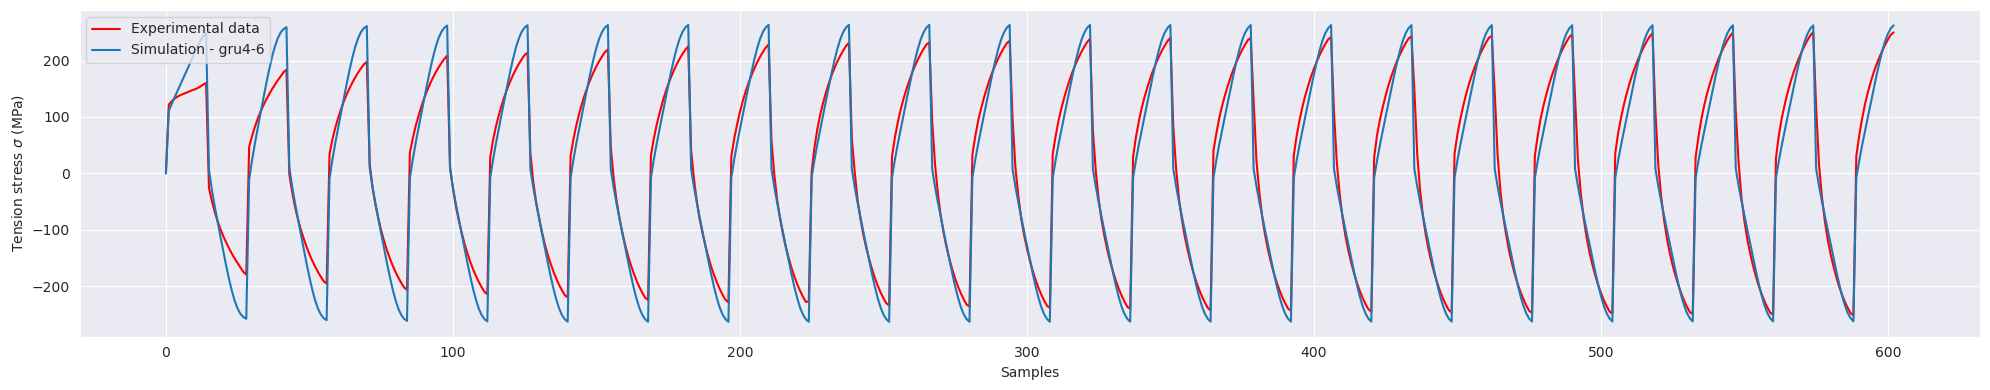

In [15]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(20,4))
    sns.lineplot(chain.real_experiment.value['2023-08-27'][0], label='Experimental data', color='red')
    plt.xlabel('Samples')
    plt.ylabel('Tension stress $\\sigma$ (MPa)')
    sns.lineplot(sig, label=f'Simulation - {chain.model_info.value["run_name"]}')
    plt.tight_layout()
    # plt.savefig(f'exp_sim_{chain.model_info.value["run_name"]}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()